# Machine Learning using Statistical Moments

This tutorial is aimed to show how to extract features from time series data using statistical moments calculated by segments, and using these features for machine learning predictions.

### Importing the data 

In [4]:
%reset
import h5py                                     # Importing the h5 package.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [5]:
filename = 'Sensor_data_2kHz.h5'                # Data filename.
f = h5py.File(filename, 'r')                    # Importing the h5 file. 

print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]

data = list(f[a_group_key])                     # Transforming data into list

sensorADC=[]                                       # Initialising a list "sensor" and
for i in range(11):                                # Filling it with data from all sensors 
    sensorADC.append(pd.DataFrame(data[i][:][:]))

for i in range(11):                             
    sensorADC[i]=sensorADC[i].iloc[:,:6291]        # Cuting the last cycle because it contains all zero elements.

print("""    
    Input matrices have dimensions: %s, where %s represents number of measurements 
    and %s represents number of cycles.""" % (np.shape(sensorADC[0]),np.shape(sensorADC[0])[0],np.shape(sensorADC[0])[1]))

Keys: <KeysViewHDF5 ['Sensor_Data']>
    
    Input matrices have dimensions: (2000, 6291), where 2000 represents number of measurements 
    and 6291 represents number of cycles.


### Converting into SI units 

In [3]:
offset=[0, 0, 0, 0, 0.00488591, 0.00488591, 0.00488591,  0.00488591, 1.36e-2, 1.5e-2, 1.09e-2]
gain=[5.36e-9, 5.36e-9, 5.36e-9, 5.36e-9, 3.29e-4, 3.29e-4, 3.29e-4, 3.29e-4, 8.76e-5, 8.68e-5, 8.65e-5]
b=[1, 1, 1, 1, 1, 1, 1, 1, 5.299641744, 5.299641744, 5.299641744]
k=[250, 1, 10, 10, 1.25, 1, 30, 0.5, 2, 2, 2]
units=['[Pa]', '[g]', '[g]', '[g]', '[kN]', '[bar]', '[mm/s]', '[A]', '[A]', '[A]', '[A]']

sensor=[0]*len(sensorADC)

for i in range(len(sensorADC)):
    sensor[i]=((sensorADC[i]*gain[i])+offset[i])*b[i]*k[i]

###### If you have problems with previous step, you can skip conversion into SI units by runing next cell.

In [ ]:
sensor=sensorADC

### Splitting data into training and testing data

Firstly, target vector is created, which assumes linear correlation between cycle number and the degree of wear of the electro-mechanical cylinder.

(6291, 1)


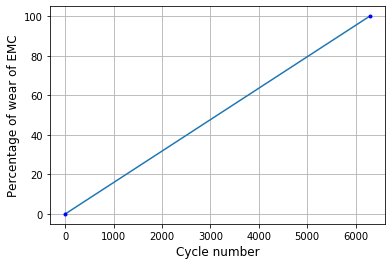

In [4]:
# Creating a target vector which will be used for correlation analysis.

target=list(np.zeros(6291))            # Making the target list which takes into account number of cycles, which-
for i in range(6291):                  # -goes from 0 to 100, and has "nCycles" elements. 
    target[i]=(i/6290)*100

target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target matrix "
print(target_matrix.shape)
plt.plot((np.array(target))*6290.0/100.0, target)
plt.xlabel("Cycle number", fontsize=12)
plt.ylabel("Percentage of wear of EMC", fontsize=12)
plt.grid()
plt.plot(6291, 100, '.', color='b')
plt.plot(0, 0, '.', color='b')



Now we need to split the raw data into training and testing data sets.
For that purpose, we use scikit.learn function train_test_split which will, in this case, choose randomly k % of the cycles into training data, and the rest of it will be used for validation. Function train_test_split is applied on target vector, and based on a selected cycles for both groups in target vector, those same cycles are extracted from the data set "sensor".

So, after this step main data to work on are lists: 

"sensor_train" with their class labels "train_target"
 
and 
 
"sensor_test" with their class labels "test_target"

In [6]:
#print(target_matrix)

from sklearn.model_selection import train_test_split

k = int(input("Enter the percentage which will be used as a traning data (recommended is 80-90): "))
target_train_vector, target_test_vector =train_test_split(target_matrix, test_size=1-k/100.)
#target_train_vector=target_train_vector.transpose()
#target_test_vector=target_test_vector.transpose()
print(target_train_vector.shape)
print(target_test_vector.shape)

target=list(target_train_vector[0])


Enter the percentage which will be used as a traning data (recommended is 80-90): 85
(5347, 1)
(944, 1)


In [7]:
sensor_train=[0]*11
sensor_test=[0]*11

for i in range(11):
    sensor_train[i]=sensor[i].loc[:,target_train_vector.index]

print("Traning data for one sensor has dimensions: ", sensor_train[10].shape,",    list 'sensor_train' ")
print("and it's target vector has length: ", target_train_vector.shape,",               'target_train_vector' \n")

for i in range(11):
    sensor_test[i]=sensor[i].loc[:,target_test_vector.index]

print("Testing data for one sensor has dimensions: ", sensor_test[10].shape,",    list 'sensor_test' ")
print("and it's target vector has length: ", target_test_vector.shape,",               'target_test_vector' \n")


Traning data for one sensor has dimensions:  (2000, 5347) ,    list 'sensor_train' 
and it's target vector has length:  (5347, 1) ,               'target_train_vector' 

Testing data for one sensor has dimensions:  (2000, 944) ,    list 'sensor_test' 
and it's target vector has length:  (944, 1) ,               'target_test_vector' 



## Feature extraction
### Feature extraction using statistical moments

This method of feature creation from time-series splits the time into smaller segments and calculates 4 statistical moments for each of these segments. Overall time interval for this data is 1 second, and size of the segment for calculation can be choosen by user. Number of features which are output of this method depends on the segment size. For example, if segment size is $0.01$, then number of segments is calculated as:

$$ N_\mathbf{seg} = \frac{1 s}{0.01 s}=100 $$

and number of points in one segment is calculated as:

$$ N_\mathbf{pts} = \frac{0.01 s}{0.0005 s}=20 $$

where $0.0005 s = \frac{1 s}{2000}$ represents timestep in this specific measurement.

For one sensor, one feature represents one statistical moment in one segment through all cycles of the EMC. With four statistical moments calculated, number of features from one sensor is then $4\cdot{}N_\mathbf{seg}$.

In [8]:
print(type(sensor_train))
print(sensor_train[10].shape)


<class 'list'>
(2000, 5347)


Definition of the main input variable, time interval over which statistical moments are calculated.

In [10]:
time_interval =0.025   # This can be changed for optimisation

n_of_samples=np.shape(sensor_train[0])[0]
segment_size= int(time_interval/0.0005)
n_of_segments=int(n_of_samples/segment_size)
segment_size

50

All these statistical moments calculations will take a while, because number of cycles is very large, and a few tens of segments are used for calculation for each cycle.

### Mean values calculation

The arithmetic mean (or simply mean) of a sample $x_{1},x_{2},\ldots ,x_{n}$ usually denoted by ${\bar {x}}$, is the sum of the sampled values divided by the number of items in the example

$${\bar {x}}={\frac {1}{n}}\left(\sum _{i=1}^{n}{x_{i}}\right)={\frac {x_{1}+x_{2}+\cdots +x_{n}}{n}}$$

This will take a while. :(

In [11]:
mean=[0]*len(sensor_train)

for i in range(len(sensor_train)):
    mean[i]=np.zeros(shape=(n_of_segments,len(sensor_train[i].columns)))
    mean[i]=pd.DataFrame(mean[i], columns=sensor_train[i].columns)
    
#print(mean[10])
import time

for i in range(len(sensor_train)):
    print("|"*(i+1),"Sensor ",i," mean calculation.", end="\r")
    for column in sensor_train[i].columns:
        for j in mean[i].index:
            mean[i].loc[j,column]=np.mean(sensor_train[i].loc[j*segment_size:(j+1)*segment_size,column])
    time.sleep(1)


You can check how does matrix of mean values look like.

In [13]:
#mean[4]

### Variance calculation

Variance measures how far a data set is spread out. The technical definition is “The average of the squared differences from the mean”, but all it really does is to give you a very general idea of the spread of your data. 

It is calculated as:

$$\sigma^{2}={\frac {1}{n-1}}\sum _{i=1}^{n}(x_{i}-{\bar {x}} )^{2}$$

where: 
    
$x_{i}=$ the $i^{th}$ data point,

${\bar {x}}=$ the mean of all data points and 

${n-1}=$ number of degrees of freedom

    
        


In [14]:
var=[0]*len(sensor_train)

for i in range(len(sensor_train)):
    var[i]=np.zeros(shape=(n_of_segments,len(sensor_train[i].columns)))
    var[i]=pd.DataFrame(var[i], columns=sensor_train[i].columns)

for i in range(len(sensor_train)):
    print("|"*(i+1),"Sensor ",i," variance calculation.", end="\r")
    for column in sensor_train[i].columns:
        for j in var[i].index:
            var[i].loc[j,column]=np.var(sensor_train[i].loc[j*segment_size:(j+1)*segment_size,column], ddof=1)
    time.sleep(1)

In [15]:
#var[0]

### Skewness calculation

Skewness is the degree of distortion from the symmetrical bell curve or the normal distribution. It measures the lack of symmetry in data distribution. It differentiates extreme values in one versus the other tail. A symmetrical distribution will have a skewness of 0.

This picture ilustrates the skewness [2]:
<img src="pictures/skew.png" width="500">

Positive skewness means when the tail on the right side of the distribution is longer or fatter. Negative skewness is when the tail of the left side of the distribution is longer or fatter than the tail on the right side.

It is calculated as:

$$skew(X)={\frac {1}{n}}\sum _{i=1}^{n}({\frac{x_{i}-{\bar {x}}}{\sigma}} )^{2}$$


In [16]:
skewness=[0]*len(sensor_train)

for i in range(len(sensor_train)):
    skewness[i]=np.zeros(shape=(n_of_segments,len(sensor_train[i].columns)))
    skewness[i]=pd.DataFrame(skewness[i], columns=sensor_train[i].columns)

from scipy.stats import skew

for i in range(len(sensor_train)):
    print("|"*(i+1),"Sensor ",i," skewness calculation.", end="\r")
    for column in sensor_train[i].columns:
        for j in skewness[i].index:
            skewness[i].loc[j,column]=skew(sensor_train[i].loc[j*segment_size:(j+1)*segment_size,column])
    time.sleep(1)

In [18]:
#skewness[10]

### Kurtosis calculation

Kurtosis is all about the tails of the distribution  —  not the peakedness or flatness. It is used to describe the extreme values in one versus the other tail. It is actually the measure of outliers present in the distribution.

- kurtosis of a normal distribution is 3
- kurtosis < 3 is termed platykurtic, this means the distribution has fewer and less extreme outliers than the normal distribution (negative)
- kurtosis > 3 is termed leptokurtic (positive)
<img src="pictures/kurt.png" width="300">

It is calculated as:

$$kurt(X)={\frac {1}{n}}\sum _{i=1}^{n}({\frac{x_{i}-{\bar {x}}}{\sigma}} )^{3}$$





In [19]:
kurtos=[0]*len(sensor_train)

for i in range(len(sensor_train)):
    kurtos[i]=np.zeros(shape=(n_of_segments,len(sensor_train[i].columns)))
    kurtos[i]=pd.DataFrame(kurtos[i], columns=sensor_train[i].columns)


from scipy.stats import kurtosis

for i in range(len(sensor_train)):
    print("|"*(i+1),"Sensor ",i," kurtosis calculation.", end="\r")
    for column in sensor_train[i].columns:
        for j in kurtos[i].index:
            kurtos[i].loc[j,column]=kurtosis(sensor_train[i].loc[j*segment_size:(j+1)*segment_size,column])
    time.sleep(1)
    

In [20]:
#kurtos[10]

Next plots are showing real signal from one sensor and one cycle and three statistical moments which are made from that signal. A lof of informations are lost here, but we will give it a try, because using this type of features extraction is the idea from ZeMA.

Text(0.5, 0, 'Points in time')

<Figure size 432x288 with 0 Axes>

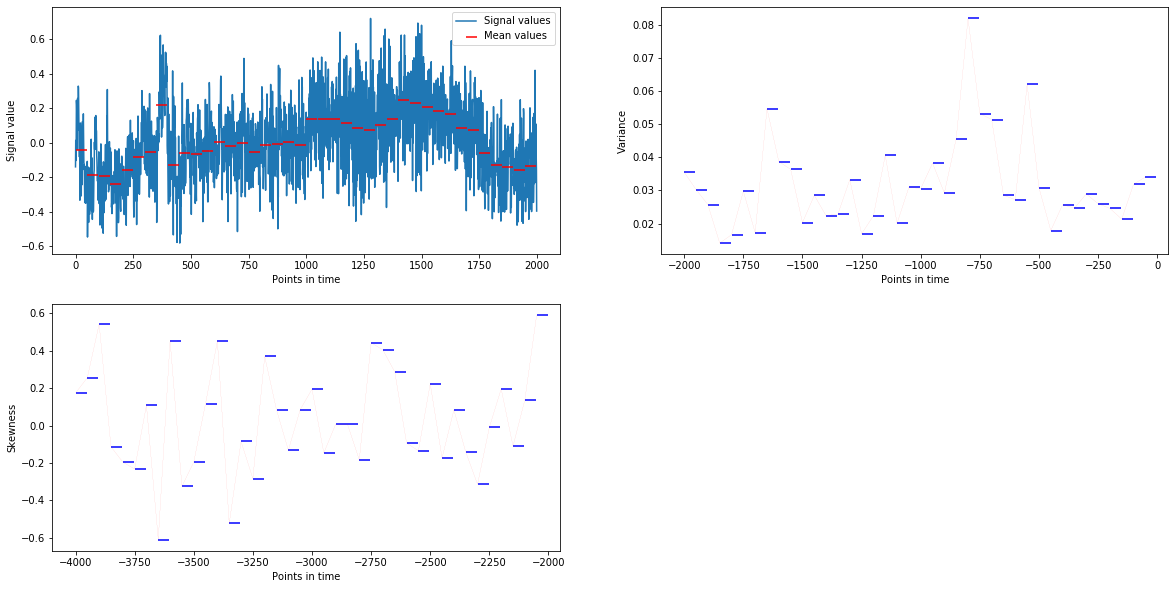

In [21]:
plt.figure(1)
plt.figure(figsize=(20,10))

plt.subplot(221)


plt.plot(sensor_train[0][5526], label="Signal values", zorder=1)
plt.scatter(mean[0].index*50, mean[0][5526], label="Mean values", marker=1,s=120, c='r',  zorder=2)
plt.ylabel("Signal value")
plt.xlabel("Points in time")
plt.legend()

plt.subplot(222)
plt.scatter(var[0].index*50-2000, var[0][5526], marker=1,s=120, c='b')
plt.plot(var[0].index*50-2000, var[0][5526], c='r', linewidth=0.05)
plt.ylabel("Variance")
plt.xlabel("Points in time")

plt.subplot(223)
plt.scatter(skewness[0].index*50-4000, skewness[0][5526], marker=1, s=120, c='b')
plt.plot(skewness[0].index*50-4000, skewness[0][5526], linewidth=0.05, c='r')
plt.ylabel("Skewness")
plt.xlabel("Points in time")

#####  Merging all 4 statistical moments and labeling rows.


All calculated features for one sensor now are merged into one matrix. First rows represent means, than next rows variances, and so on. From 11 sensors, 11 of these matrices are created below.

In [28]:
for i in range(len(sensor_train)):
    var[i].index=list(range(n_of_segments,2*n_of_segments))
    skewness[i].index=list(range(2*n_of_segments,3*n_of_segments))
    kurtos[i].index=list(range(3*n_of_segments,4*n_of_segments))

print("Number of splitting segments in time is",n_of_segments,".\n")
print("Row indices for mean are from %s to %s." %(0,n_of_segments-1))
print("Row indices for variance are from %s to %s." %(n_of_segments,2*n_of_segments-1))
print("Row indices for skewness are from %s to %s." %(2*n_of_segments,3*n_of_segments-1))
print("Row indices for kurtosis are from %s to %s." %(3*n_of_segments,4*n_of_segments-1))

Number of splitting segments in time is 40 .

Row indices for mean are from 0 to 39.
Row indices for variance are from 40 to 79.
Row indices for skewness are from 80 to 119.
Row indices for kurtosis are from 120 to 159.


List 'm_v_s_k' contains merged feature matrices. (Mean_Variance_Skewness_Kurtosis)

In [29]:
m_v_s_k=[0]*len(sensor_train)

for i in range(len(sensor_train)):
    m_v_s_k[i]=(pd.concat([mean[i], var[i], skewness[i], kurtos[i]])).transpose()


In [30]:
print(type(m_v_s_k[0]))
print(m_v_s_k[0].shape)

<class 'pandas.core.frame.DataFrame'>
(5347, 160)


In [31]:
print("Each sensor now has %s features, which means that overall number of features is %s." % (4*n_of_segments, 4*11*n_of_segments))
print("\nSize of features matrix for one sensor is", m_v_s_k[0].shape,".")

Each sensor now has 160 features, which means that overall number of features is 1760.

Size of features matrix for one sensor is (5347, 160) .


We can plot features from all the sensors which are stored in m_v_s_k using indices from 0 to 10. Using `head()` function, features for 5 samples are shown. These are random samples, because after splitting data, samples are randomly ordered.

In [32]:
m_v_s_k[0].head()

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
6278,1.117462,0.906952,1.030948,1.214536,1.093717,1.108394,1.023551,0.726318,0.550126,0.662268,...,-0.237255,-0.154390,-0.397335,1.596608,-0.137494,-0.698254,-0.471277,-0.822719,-0.788593,-0.875385
5262,0.043555,-0.081970,-0.403884,-0.450764,-0.460462,-0.083996,0.127420,0.349536,0.148050,-0.266354,...,0.027026,1.160510,-0.174817,0.684012,-0.093800,-0.274924,-0.500529,-0.668513,-0.112342,0.283735
6263,0.026383,-0.144702,-0.335896,-0.272856,-0.106656,-0.091524,-0.109260,-0.084317,-0.159781,-0.218526,...,-0.447563,-1.017549,0.501080,-0.333601,-0.463418,0.639175,0.666852,-1.046713,-0.101387,-0.972762
5527,-0.312423,-0.372503,-0.266253,-0.260687,-0.291585,-0.241707,-0.313392,0.203487,-0.176306,-0.393018,...,0.010841,0.555047,-0.772324,-0.495739,0.175006,-0.006308,-0.120618,-0.537207,-0.699190,-0.242821
5903,0.026272,0.100663,-0.006815,-0.044191,0.010670,0.032900,0.037997,0.019415,-0.028371,-0.052879,...,-1.049687,-0.342825,-0.178453,0.023184,-0.725976,-0.008414,-0.754110,-0.007632,-0.405794,-0.962859


Target vector for the same samples is showed here.

In [42]:
target_train_vector.head()

,0
6278,99.809221
5262,83.656598
6263,99.570747
5527,87.869634
5903,93.847377


## Feature selection 
### Feature selection using Pearson correlation coefficients

This step is done with knowledge of cycle‘s group affiliation. Selection is based on a target vector which represents label for each cycle. The method is very simple, Pearson correlation coefficient is calculated between choosen features and target vector and it is done for all sensors. After that, number of features with overall highest Pearson correlation coefficients is selected.

#### Pearson correlation

A Pearson correlation is a number between -1 and 1 that indicates the extent to which two variables are linearly related. A correlation coefficient indicates the extent to which dots in a scatterplot lie on a straight line. The stronger the association of the two variables, the closer the Pearson correlation coefficient, r, will be to either +1 or -1 depending on whether the relationship is positive or negative, respectively.

_Pearson correlation formula [3]:_

<img src="pictures/formula1.png">

- $x$ and $y$ are two vectors of length n
- $m_x$ and $m_y$ corresponds to the means of x and y, respectively.

Different relationships and their correlation coefficients are shown in the figure below [4]:

<img src="pictures/Correlation_examples.png">

Firstly, correlation coefficients are calculated for all features and their values are stored in the list "corr". Then, function called 'largest_indices' finds indices of wanted amount of features with highest correlation coefficients. Function output is stored into lists 'sensor_n' and 'feature_n', where element in 'sensor_n' means which sensor, and related element in 'feature_n' means which feature of that sensor is accessed.

Example:
If element in 'senzor_n' is 5, and the element in 'feature_n' at the same position is 50, that means that you can access that feature in this way:

``` python
    m_v_s_k[5].iloc[:][50]
```

In [43]:
from scipy.stats import pearsonr

n_features_for_select=0
for i in range(len(m_v_s_k)):
    n_features_for_select=n_features_for_select+int(len(m_v_s_k[i].iloc[0][:]))
    
n_of_features = int(input("How many features out of %s you want to select: " % n_features_for_select))
                                    # Defining how much of features with biggest Pearson correllation coeff.- 
                                    # -will be choosen.

print("\nDimension of target matrix is:")
print("                                                 ", target_train_vector.shape)
print("Dimension of amplitude matrix for one sensor is:")
print("                                                 ", m_v_s_k[0].iloc[:][:].shape)

corr=list(range(11))                      # Making list for correlation coefficients.
p_value=list(range(11))

for j in range(11):                       # Making sublists in "corr" for each sensor.
    corr[j]=list(range(round(4*n_of_segments)))
    p_value[j]=list(range(round(4*n_of_segments)))

# Calculating correlation coefficients for each column of each sensor with respect to target.
for j in range(11):
    for i in range(round(4*n_of_segments)):
        corr[j][i],p_value[j][i]=pearsonr(m_v_s_k[j].iloc[:][i].values,target_train_vector[0].values)
matrix_corr_coeff = np.transpose(pd.DataFrame(corr))# Transforming list of correlation coefficients to data frame.

print("Matrix of correlation coefficients has size:")
print("                                                 ", matrix_corr_coeff.shape)

corr_array=np.array(corr)                                   # Transforming list of correlation coefficients to nparray

print("Array of correlation coefficients has size:")
print("                                                 ",corr_array.shape)  


def largest_indices(array, n):                               # Function that find indices for 500 biggest Pearson-
    """Returns the n largest indices from a numpy array."""  # -correlation coefficients.
    flat = array.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, array.shape)  

# Sensor_n is the index of the sensor number.
# Feature_n is the index of the feature number for each sensor number.
sensor_n, feature_n = largest_indices(corr_array, n_of_features)

print("Sensor indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
print(sensor_n)
print("\nColumn indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
print(feature_n)



How many features out of 1760 you want to select: 500

Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 160)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Matrix of correlation coefficients has size:
                                                  (160, 11)
Array of correlation coefficients has size:
                                                  (11, 160)
Sensor indices of location of features in >sorted_values_from_all_sensors< matrix: 

[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10  2 10 10 10 10 10  5 10  2 10  9  9  9  5  9  9
  9  9  9  9  9  9  9 10  9  5  9  9  9  9  2  3  9  9  9  9  9  2  2  9
  2  9  9  7  7  7  7  7  7  7  7  9  7  9  7  7  8  9  9  9  9  7  9  7
  7  7  9  9  7  7  7  9  7  7 10  9  9  7  9  7  3  7  7  9  0  3  9  7
  9  7  7  8  7  7  7  3  3  2  8  7  7  6  7  7  9  7  7  0  9  0  7  2
  0  9  7  7  7  0  3  2 10  7  7  3  7  7  9  8  0  8  7  2  2  7  8  7
  7  8  7  8  0  8  8 10  0  8  0 10  1  0  8  8  8  8  8  3  0  0  8  7
  7  8  3 10  3  8  8  8  2  7  3  8  7  7  7  0  7  8  8  8  9  7  3  0
  7  6  3  8  8  8  8  7  7  8  7  6  8  7  8  8 

This **error** is showing that calculations of Pearson correlation didn't go very well. That means that Pearson correlation is **not defined** for some of the features. Reason for that could be because the variance of these features is zero or very close to zero. If we check for a NaN values in the array of correlation coefficient, we wil see that there are some of these.

In [49]:
pd.DataFrame(corr_array).isnull().values.any() # If statement is True, NaN values exist.

True

Based on the found indices for highest features, all of them are put together into a list 'top_n_features', but separated by sensor they are taken from. Then, by comparing the sizes of these groups it is shown how many of those selected features are from which sensor.

After that, they are merged into one feature matrix 'top_n_together_matrix', and all steps from here on are done on these features with absolute values.

One gets to choose which two features to plot to see example of features correlating betwwen and with the target vector.


<class 'pandas.core.frame.DataFrame'> 

Enter indices of two features out of 500 for ploting: 50 300


Number of features from sensor  0 is:  26 or  5.20 %
Number of features from sensor  1 is:  11 or  2.20 %
Number of features from sensor  2 is:  36 or  7.20 %
Number of features from sensor  3 is:  25 or  5.00 %
Number of features from sensor  4 is:   8 or  1.60 %
Number of features from sensor  5 is:  61 or  12.20 %
Number of features from sensor  6 is:  52 or  10.40 %
Number of features from sensor  7 is:  79 or  15.80 %
Number of features from sensor  8 is:  67 or  13.40 %
Number of features from sensor  9 is:  67 or  13.40 %
Number of features from sensor 10 is:  68 or  13.60 %
----------------------------------------------------
                                             100.00


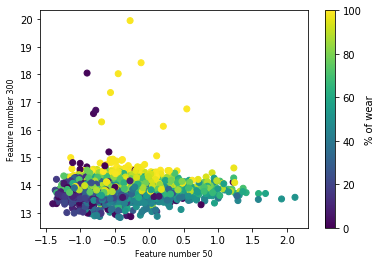

In [52]:
# Initialising a list of best features. 11 sublists containing features from each sensor, respectively.
top_n_features=[[], [], [], [], [], [], [], [], [], [], []]
for i in range(len(sensor)):
    for j in range(len(sensor_n)):
        if sensor_n[j]==i:
            top_n_features[i].append(m_v_s_k[i].iloc[:][feature_n[j]]);
            
# Transforming elements of sublists into lists.
for i in range(len(sensor)):
    for j in range(len(top_n_features[i])):
        top_n_features[i][j]=list(top_n_features[i][j])


top_n_together=[j for i in top_n_features for j in i]  # Merging sublists into one list with all elements of all sublists.


top_n_together_matrix=np.transpose(pd.DataFrame(top_n_together))
print(type(top_n_together_matrix), "\n")


x1, x2 = input("Enter indices of two features out of %s for ploting: " % n_of_features).split()
x1, x2 = [int(x1), int(x2)]

print("\n")
plt.scatter(top_n_together_matrix[x1], top_n_together_matrix[x2],c=target_train_vector[0])
plt.xlabel('Feature number %s' % x1 ,fontsize=8)
plt.ylabel('Feature number %s' % x2 ,fontsize=8)
plt.colorbar().set_label('% of wear',fontsize=10 ,rotation=90)
percentage=list(range(11))
k=0
for i in range(len(sensor)):
    #print(top_n_features_matrix.shape)
    print("Number of features from sensor %2.0f is: %3.0f or  %4.2f %%" % (i, len(top_n_features[i]), len(top_n_features[i])/len(sensor_n)*100))
    percentage[i]=len(top_n_features[i])
    k=k+len(top_n_features[i])/len(sensor_n)*100
print("----------------------------------------------------")
print("                                             %4.2f" % (k))

Percentages of features from each sensor are:


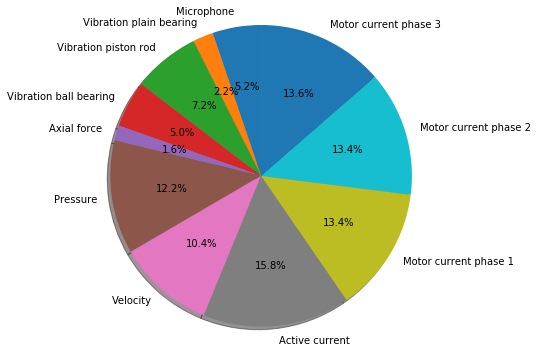

In [51]:
labels = 'Microphone','Vibration plain bearing','Vibration piston rod','Vibration ball bearing', 'Axial force','Pressure','Velocity','Active current','Motor current phase 1','Motor current phase 2','Motor current phase 3'
print("Percentages of features from each sensor are:")

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(percentage, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, )
ax1.axis('equal')

plt.show()

## Classification

First we will try to apply LDA traning model for which description is available in `2_Machine_Learning_using_Best_Fourier_Coefficients.ipynb`. We want to see if these extracted features are usefull for predicting the outcome.

Target vector is now redefined from that used in Pearson correlation calculation and clustered by segments. It is made in order to make class labels. Classes are integers from 1 to 100 and target vector is transformed in such way that for instance, class 2 are all cycles with EMC wear between 1 and 2, including 2, but not including 1, etc. 

In [126]:
# Definition of new target with rounding to first higher number.

class_target_train_vector=np.ceil(target_train_vector[0])

for i in class_target_train_vector.index:
    if class_target_train_vector[i]==0:
        class_target_train_vector[i]=1                #Fixing the zero element.

In [127]:
X_train = np.array(top_n_together_matrix)          # Feature matrix.
y_train = np.array(class_target_train_vector)      # Target vector.

print(X_train.shape)
print(y_train.shape)


(5347, 500)
(5347,)


We will scale the features before using LDA.

<Figure size 432x288 with 0 Axes>

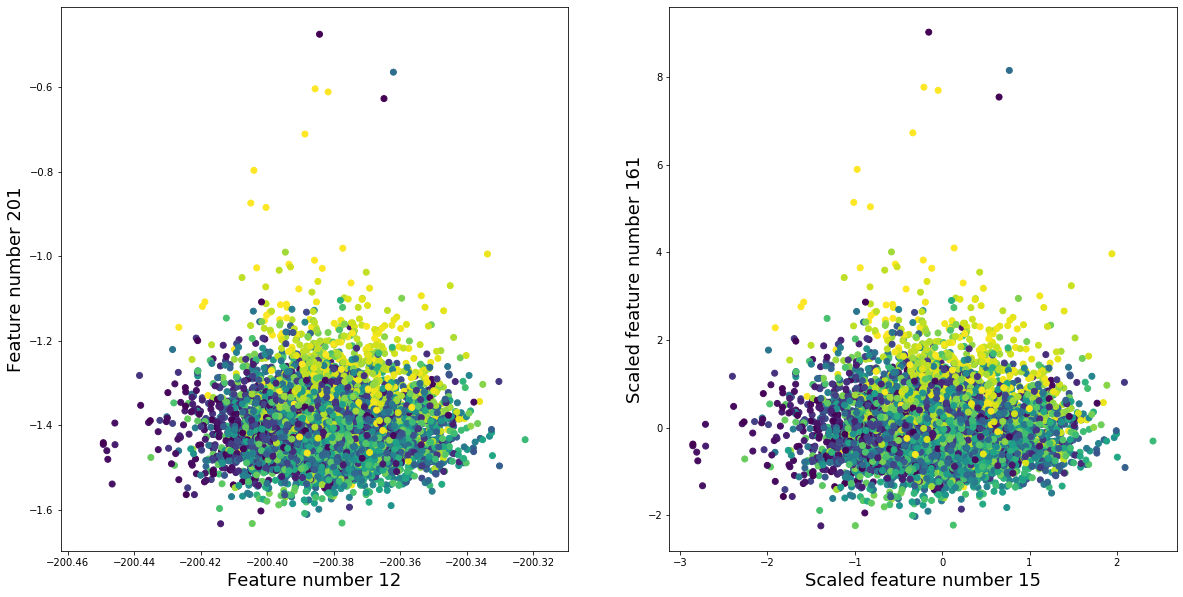

In [128]:
# Scaling features

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

X_train_scaled=RobustScaler(quantile_range=(25, 75)).fit_transform(X_train)             # Method 1 
#X_scaled=QuantileTransformer(output_distribution='uniform').fit_transform(X_train)     # Method 2
#X_scaled=PowerTransformer(method='yeo-johnson').fit_transform(X_train)                 # Method 3

plt.figure(1)
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.scatter(X_train[:,200], X_train[:,180], c=y_train)                   #(X[:,0], X[:,1],c=np.arange(y))
plt.xlabel("Feature number 12", fontsize=18)
plt.ylabel("Feature number 201", fontsize=18)

plt.subplot(122)
plt.scatter(X_train_scaled[:,200], X_train_scaled[:,180], c=y_train)    #(X[:,0], X[:,1],c=np.arange(y))
plt.xlabel("Scaled feature number 15", fontsize=18)
plt.ylabel("Scaled feature number 161", fontsize=18)

plt.show()

After scaling, good thing to try is to remove zero variance or low variance features from data.

In [129]:
from sklearn.feature_selection import VarianceThreshold

# Create VarianceThreshold object with a variance with a threshold of 1 (parameter can be changed)
thresholder = VarianceThreshold(threshold=0.6)

# Conduct variance thresholding
X_train_high_variance = thresholder.fit_transform(X_train_scaled)

print('After removing low variance features, we have ',X_train_high_variance.shape[1],' features left.')

After removing low variance features, we have  301  features left.


#### Now, first try with LDA .....

(5347, 3)


<Figure size 432x288 with 0 Axes>

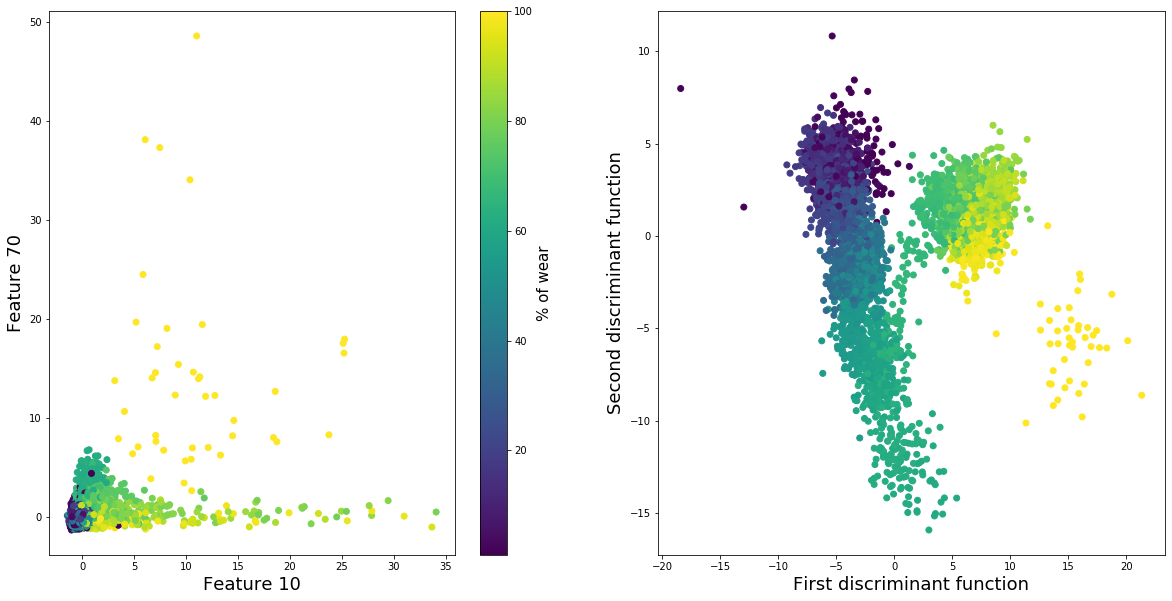

In [130]:
#LDA analysis

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
                                        
LDA1 = LinearDiscriminantAnalysis(n_components=3,priors=None, shrinkage=None, solver='svd')

Y_train=LDA1.fit_transform(X_train_high_variance,y_train)

plt.figure(1)
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.scatter(X_train_high_variance[:,9], X_train_high_variance[:,69], c=y_train)                   #(X[:,0], X[:,1],c=np.arange(y))
plt.xlabel("Feature 10", fontsize=18)
plt.ylabel("Feature 70", fontsize=18)
plt.colorbar().set_label('% of wear',fontsize=15 ,rotation=90)

plt.subplot(122)
plt.scatter(Y_train[:,0], Y_train[:,1], c=y_train)                   #(X[:,0], X[:,1],c=np.arange(y))
plt.xlabel("First discriminant function", fontsize=18)
plt.ylabel("Second discriminant function", fontsize=18)

print(Y_train.shape)                                        # Discrimnant functions matrix

plt.show()

From right plot, which is showing first two discriminant functions, we don't see very good class separation. BFC method for feature extraction showed much better results than this one.

Let's try with removing features with high correlation between themselfs. For that we will use variance inflation factor. High VIF factor for one feature means that it is highly correlated with the other features. 

In [131]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X_train_high_variance, i) for i in range(X_train_high_variance.shape[1])]

vif_under_3 = pd.DataFrame()
vif_under_3 = vif[vif.VIF_Factor < 3]
X_low_VIF = (pd.DataFrame(X_train_high_variance)[vif_under_3.index]).values

        

In [132]:
#vif_under_3

In [133]:
print('After removing low variance features, we have ',X_low_VIF.shape[1],' features left.')

After removing low variance features, we have  92  features left.


#### Second try LDA ....

(5347, 3)


<Figure size 432x288 with 0 Axes>

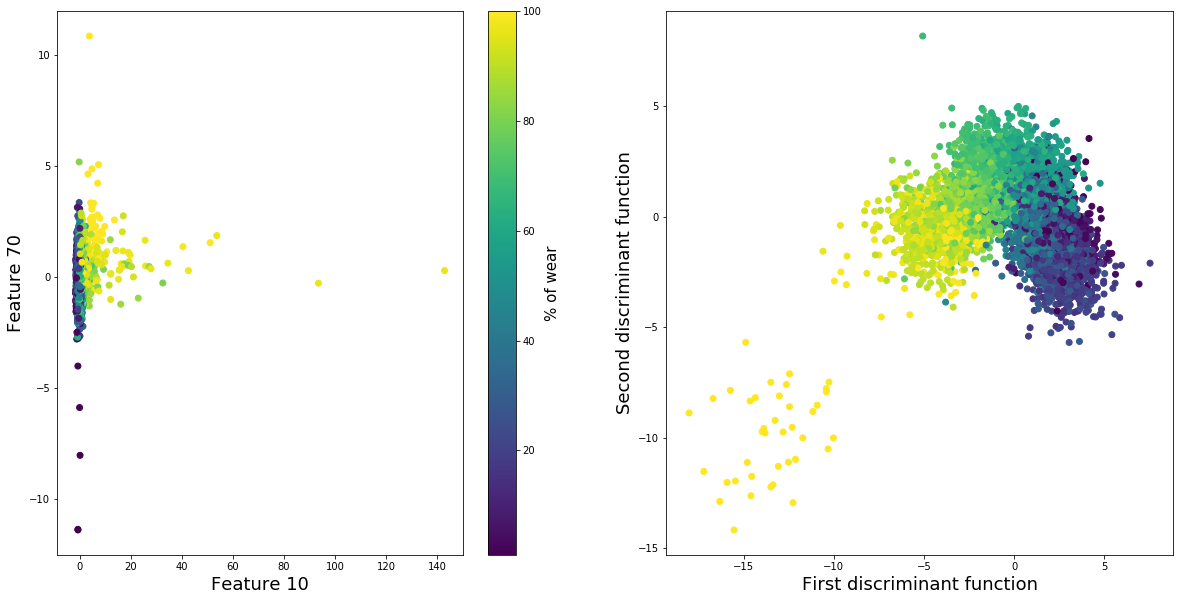

In [134]:
#LDA analysis

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
                                        
LDA2 = LinearDiscriminantAnalysis(n_components=3,priors=None, shrinkage=None, solver='svd')

Y_train=LDA2.fit_transform(X_low_VIF,y_train)

plt.figure(1)
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.scatter(X_low_VIF[:,9], X_low_VIF[:,69], c=y_train)                   #(X[:,0], X[:,1],c=np.arange(y))
plt.xlabel("Feature 10", fontsize=18)
plt.ylabel("Feature 70", fontsize=18)
plt.colorbar().set_label('% of wear',fontsize=15 ,rotation=90)

plt.subplot(122)
plt.scatter(Y_train[:,0], Y_train[:,1], c=y_train)                   #(X[:,0], X[:,1],c=np.arange(y))
plt.xlabel("First discriminant function", fontsize=18)
plt.ylabel("Second discriminant function", fontsize=18)

print(Y_train.shape)                                        # Discrimnant functions matrix

plt.show()

Obviously, this method is not giving good features for predicting the lifetime, and we should stick to the Best Fourier Coefficients method.

### References:

[1]  PTB, ZeMA, - Deep dive into the ZeMA machine learning (ppt), January 2019

[2]  https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft

[3]  http://www.sthda.com/english/wiki/correlation-test-between-two-variables-in-r

[4]  https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

[4]  Edouard Duchesnay, Tommy Löfstedt, - Statistics and Machine Learning in Python, March 2018


